## Project Objectives

- Objective: hourly energy demand
- Target: load, price
- Type: day ahead (24h)

## Datasets

1. energy_dataset:

    Power system (actuals by hour)
    - time — Timestamp of the delivery hour (usually ISO 8601). Use UTC internally; handle DST carefully.

    - generation biomass — Electricity generated from biomass, in MW (instantaneous average over the hour).

    - generation fossil brown coal/lignite — Lignite-fired generation, MW.

    - generation fossil coal-derived gas — Coal-gas derived generation, MW.

    - generation fossil gas — Natural gas generation, MW.

    - generation fossil hard coal — Hard/bituminous coal generation, MW.

    - generation fossil oil — Oil-fired generation, MW.

    - generation fossil oil shale — Oil-shale–based generation, MW.

    - generation fossil peat — Peat-fueled generation, MW.

    - generation geothermal — Geothermal generation, MW.

    - generation hydro pumped storage aggregated — Net pumped-storage generation (aggregate), MW (positive = generating).

    - generation hydro pumped storage consumption — Pumped-storage pumping load/consumption, MW (positive = consuming).

    - generation hydro run-of-river and poundage — Run-of-river hydro generation, MW.

    - generation hydro water reservoir — Reservoir hydro generation, MW.

    - generation marine — Tidal/wave (marine) generation, MW.

    - generation nuclear — Nuclear generation, MW.

    - generation other — Other unspecified generation sources, MW.

    - generation other renewable — Other renewables not listed elsewhere (e.g., biomass waste-to-energy if categorized so), MW.

    - generation solar — Solar PV generation, MW.

    - generation waste — Waste-to-energy generation, MW.

    - generation wind offshore — Offshore wind generation, MW.

    - generation wind onshore — Onshore wind generation, MW.

    Forecasts (known at/ before the forecast time)

    - forecast solar day ahead — Day-ahead solar generation forecast, MW for each hour of the next day (feature; avoid using realized future solar).

    - forecast wind offshore day ahead (your list says “offshore eday ahead”; assume a typo) — Day-ahead offshore wind forecast, MW.

    - forecast wind onshore day ahead — Day-ahead onshore wind forecast, MW.

    - total load forecast — System load forecast made day-ahead or intra-day, MW (feature; do not use future actuals).

    - price day ahead — Day-ahead market price for the delivery hour, EUR/MWh (can be negative).

    Load & price targets
    - total load actual — Realized system load (demand), MW.

    - price actual — Realized/settlement price (if provided; may be balancing or intraday realized), EUR/MWh.

2. Weather (typically hourly, by city/area)
    - dt_iso — Weather observation/forecast timestamp (ISO 8601; confirm whether this is UTC or local from the source).

    - city_name — Name/identifier of the weather location (join key if multiple stations).

    - temp — Air temperature at 2 m, °C.

    - temp_min — Min temperature over the last/next observation window, °C (API-dependent).

    - temp_max — Max temperature over the last/next observation window, °C.

    - pressure — Atmospheric pressure at sea level, hPa.

    - humidity — Relative humidity, %.

    - wind_speed — Wind speed, typically m/s (sometimes km/h; check the data source).

    - wind_deg — Wind direction in degrees (0–360, meteorological).

    - rain_1h — Rainfall volume in the last 1 h, mm.

    - rain_3h — Rainfall volume in the last 3 h, mm.

    - snow_3h — Snowfall volume in the last 3 h, mm (water equivalent).

    - clouds_all — Cloudiness, % (0–100).

    - weather_id — Weather condition code (numeric category).

    - weather_main — High-level weather category (e.g., Rain, Snow).

    - weather_description — Human-readable description (e.g., “light rain”).

    - weather_icon — Icon code string (display-only; not predictive).

## Global Config

In [1]:
TARGET = ["load", "price"]

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# display all pandas columns
pd.set_option('display.max_columns', None)


## 1. EDA and Cleaning

In [4]:
energy_data = pd.read_csv("/Users/shanzhonghan/Documents/Data/energy_dataset.csv", parse_dates=["time"])
weather_data = pd.read_csv("/Users/shanzhonghan/Documents/Data/weather_features.csv", parse_dates=["dt_iso"])

### 1.1 Energy dataset

In [5]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [6]:
# Overall information
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [7]:
# number of unique 
energy_data.nunique()

time                                           35064
generation biomass                               423
generation fossil brown coal/lignite             956
generation fossil coal-derived gas                 1
generation fossil gas                           8297
generation fossil hard coal                     7266
generation fossil oil                            321
generation fossil oil shale                        1
generation fossil peat                             1
generation geothermal                              1
generation hydro pumped storage aggregated         0
generation hydro pumped storage consumption     3311
generation hydro run-of-river and poundage      1684
generation hydro water reservoir                7029
generation marine                                  1
generation nuclear                              2388
generation other                                 103
generation other renewable                        78
generation solar                              

In [8]:
# Drop null columns and constant columns

drop_cols = ["generation fossil coal-derived gas", 
             "generation fossil oil shale", 
             "generation fossil peat", 
             "generation geothermal", 
             "generation hydro pumped storage aggregated", 
             "generation marine", 
             "generation wind offshore", 
             "forecast wind offshore eday ahead",
             ]

energy_data = energy_data.drop(columns=drop_cols)

In [9]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [10]:
# Convert time column to datetime type and set it as index
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True, infer_datetime_format=True).dt.floor("h")
energy_data = energy_data.set_index("time").sort_index()


In [13]:
# duplicated rows
duplicate_rows = energy_data[energy_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [15]:
# time continuity check
time_diff = energy_data.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals: {len(missing_intervals)}")

Number of missing time intervals: 0


In [14]:
# null values
energy_data.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


In [16]:
# total rows
total_rows = energy_data.shape[0]
print(f"Total rows: {total_rows}")

Total rows: 35064


Comparing the total number of the samples, there are only few missing features. We only need to check the target column: total load actual:

In [ ]:
# find the missing rows of the target column 'total load actual'
missing_target_rows = energy_data[energy_data["total load actual"].isnull()]

missing_target_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,23209.0,NaN,35.50,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,23725.0,NaN,36.80,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,23614.0,NaN,32.50,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,22381.0,NaN,30.00,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,21371.0,NaN,30.00,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,20760.0,NaN,30.60,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4136.0,6223.0,36239.0,NaN,65.00,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,18.0,3141.0,24379.0,NaN,56.10,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,63.0,3165.0,27389.0,NaN,57.69,19.56


The gaps are scattered across the time range, so we apply a forward fill to impute short gaps and remove any initial missing values.

In [ ]:
print(f"total rows: {energy_data.shape[0]}, missing target rows: {missing_target_rows.shape[0]} before imputation:")
energy_data = energy_data.ffill().dropna()
energy_data.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [22]:
print(f"Data shape after cleaning: {energy_data.shape}")

Data shape after cleaning: (35064, 20)


In [ ]:
# Overall information after cleaning
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

### 1.2 Visualization

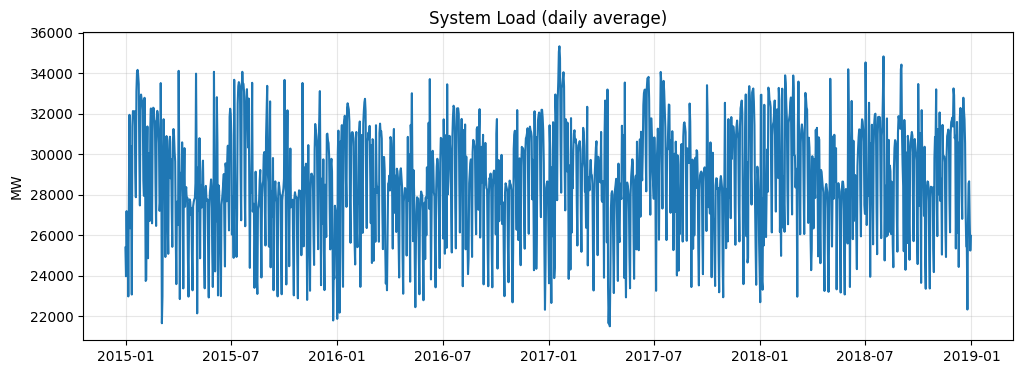

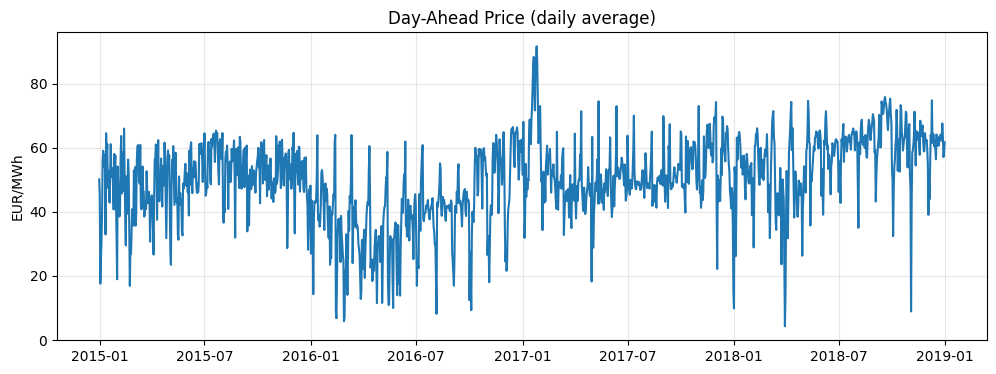

In [ ]:
# Load & Price: Overall Trend (Hourly → Daily Mean, Denoised)

daily = energy_data[['total load actual','price day ahead']].resample('D').mean()

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(daily.index, daily['total load actual'], label='Load (daily mean)')
ax1.set_ylabel('MW')
ax1.set_title('System Load (daily average)')
ax1.grid(True, alpha=0.3)

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(daily.index, daily['price day ahead'], label='DA Price (daily mean)')
ax2.set_ylabel('EUR/MWh')
ax2.set_title('Day-Ahead Price (daily average)')
ax2.grid(True, alpha=0.3)
plt.show()


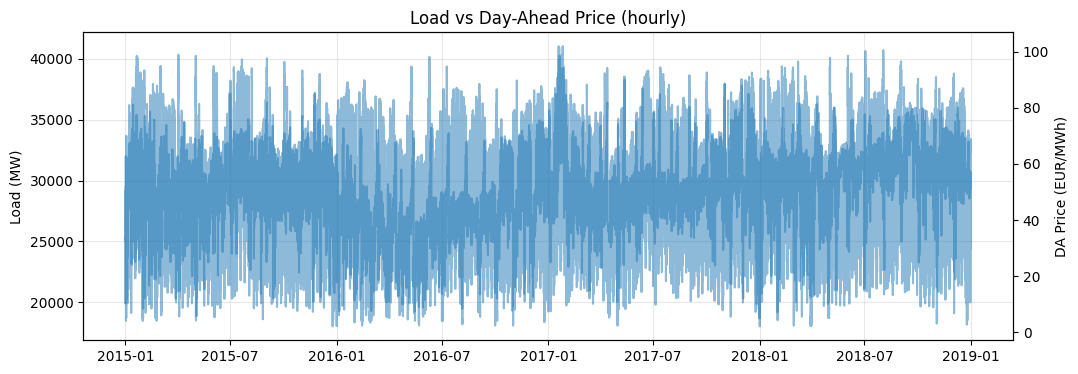

In [ ]:
# Load & Price: Dual-Axis View (Hourly Detail)

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(energy_data.index, energy_data['total load actual'], alpha=0.5)
ax1.set_ylabel('Load (MW)')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(energy_data.index, energy_data['price day ahead'], alpha=0.5)
ax2.set_ylabel('DA Price (EUR/MWh)')
ax1.set_title('Load vs Day-Ahead Price (hourly)')
plt.show()


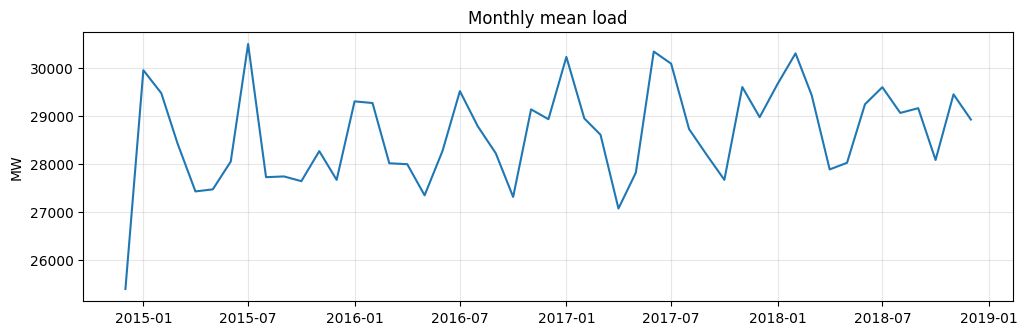

In [31]:
# Seasonality – Monthly

monthly = energy_data['total load actual'].resample('MS').mean()
fig, ax = plt.subplots(figsize=(12,3.5))
ax.plot(monthly.index, monthly.values)
ax.set_title('Monthly mean load')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)

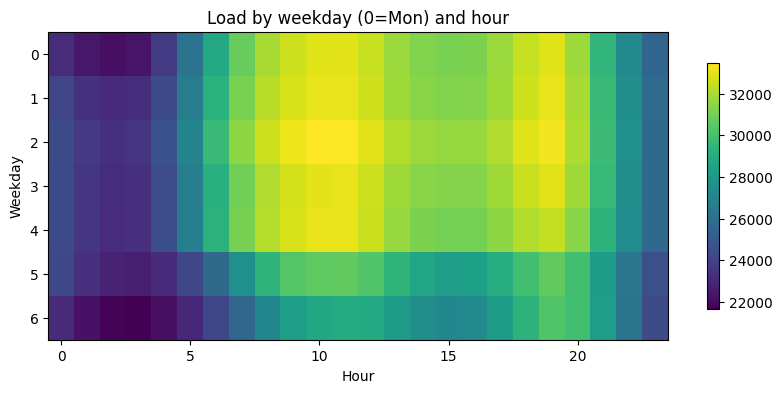

In [32]:
# Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['total load actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(gp, aspect='auto')
ax.set_title('Load by weekday (0=Mon) and hour')
ax.set_xlabel('Hour'); ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
plt.show()


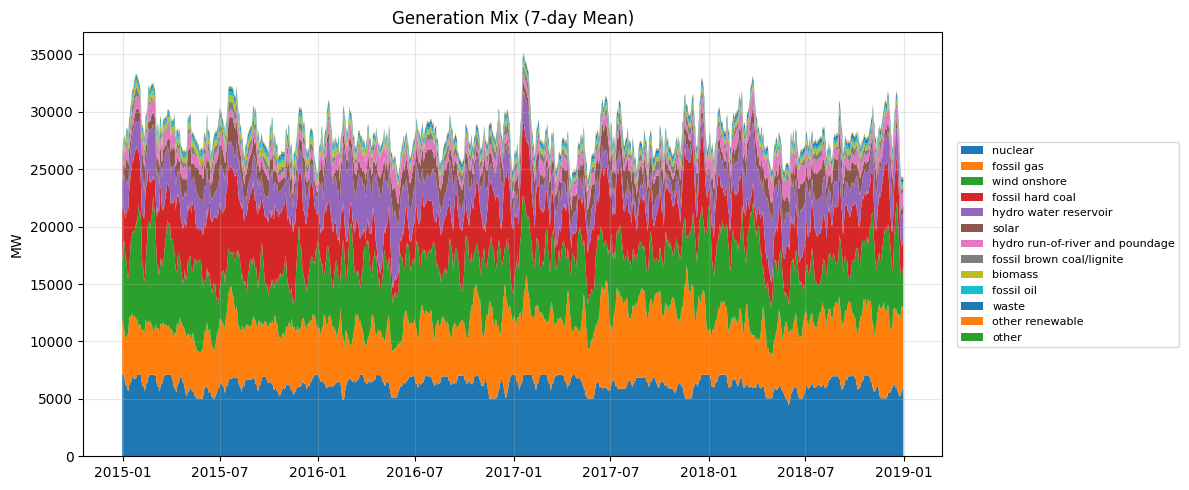

In [ ]:
# Generation Mix (Daily Mean): 

gen_cols = [c for c in energy_data.columns if c.startswith('generation ') and
            'pumped storage consumption' not in c]  # 
# Daily mean to reduce visual noise
gen_daily = energy_data[gen_cols].resample('D').mean()
gen_smooth = gen_daily.rolling(window=7, min_periods=1).mean()

order = gen_smooth.mean().sort_values(ascending=False).index
labels = [c.replace('generation ', '') for c in order]

fig, ax = plt.subplots(figsize=(12,5))
ax.stackplot(gen_smooth.index, gen_smooth[order].T.values, labels=labels)
ax.set_title('Generation Mix (7-day Mean)')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)
ax.legend(ncols=1, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()


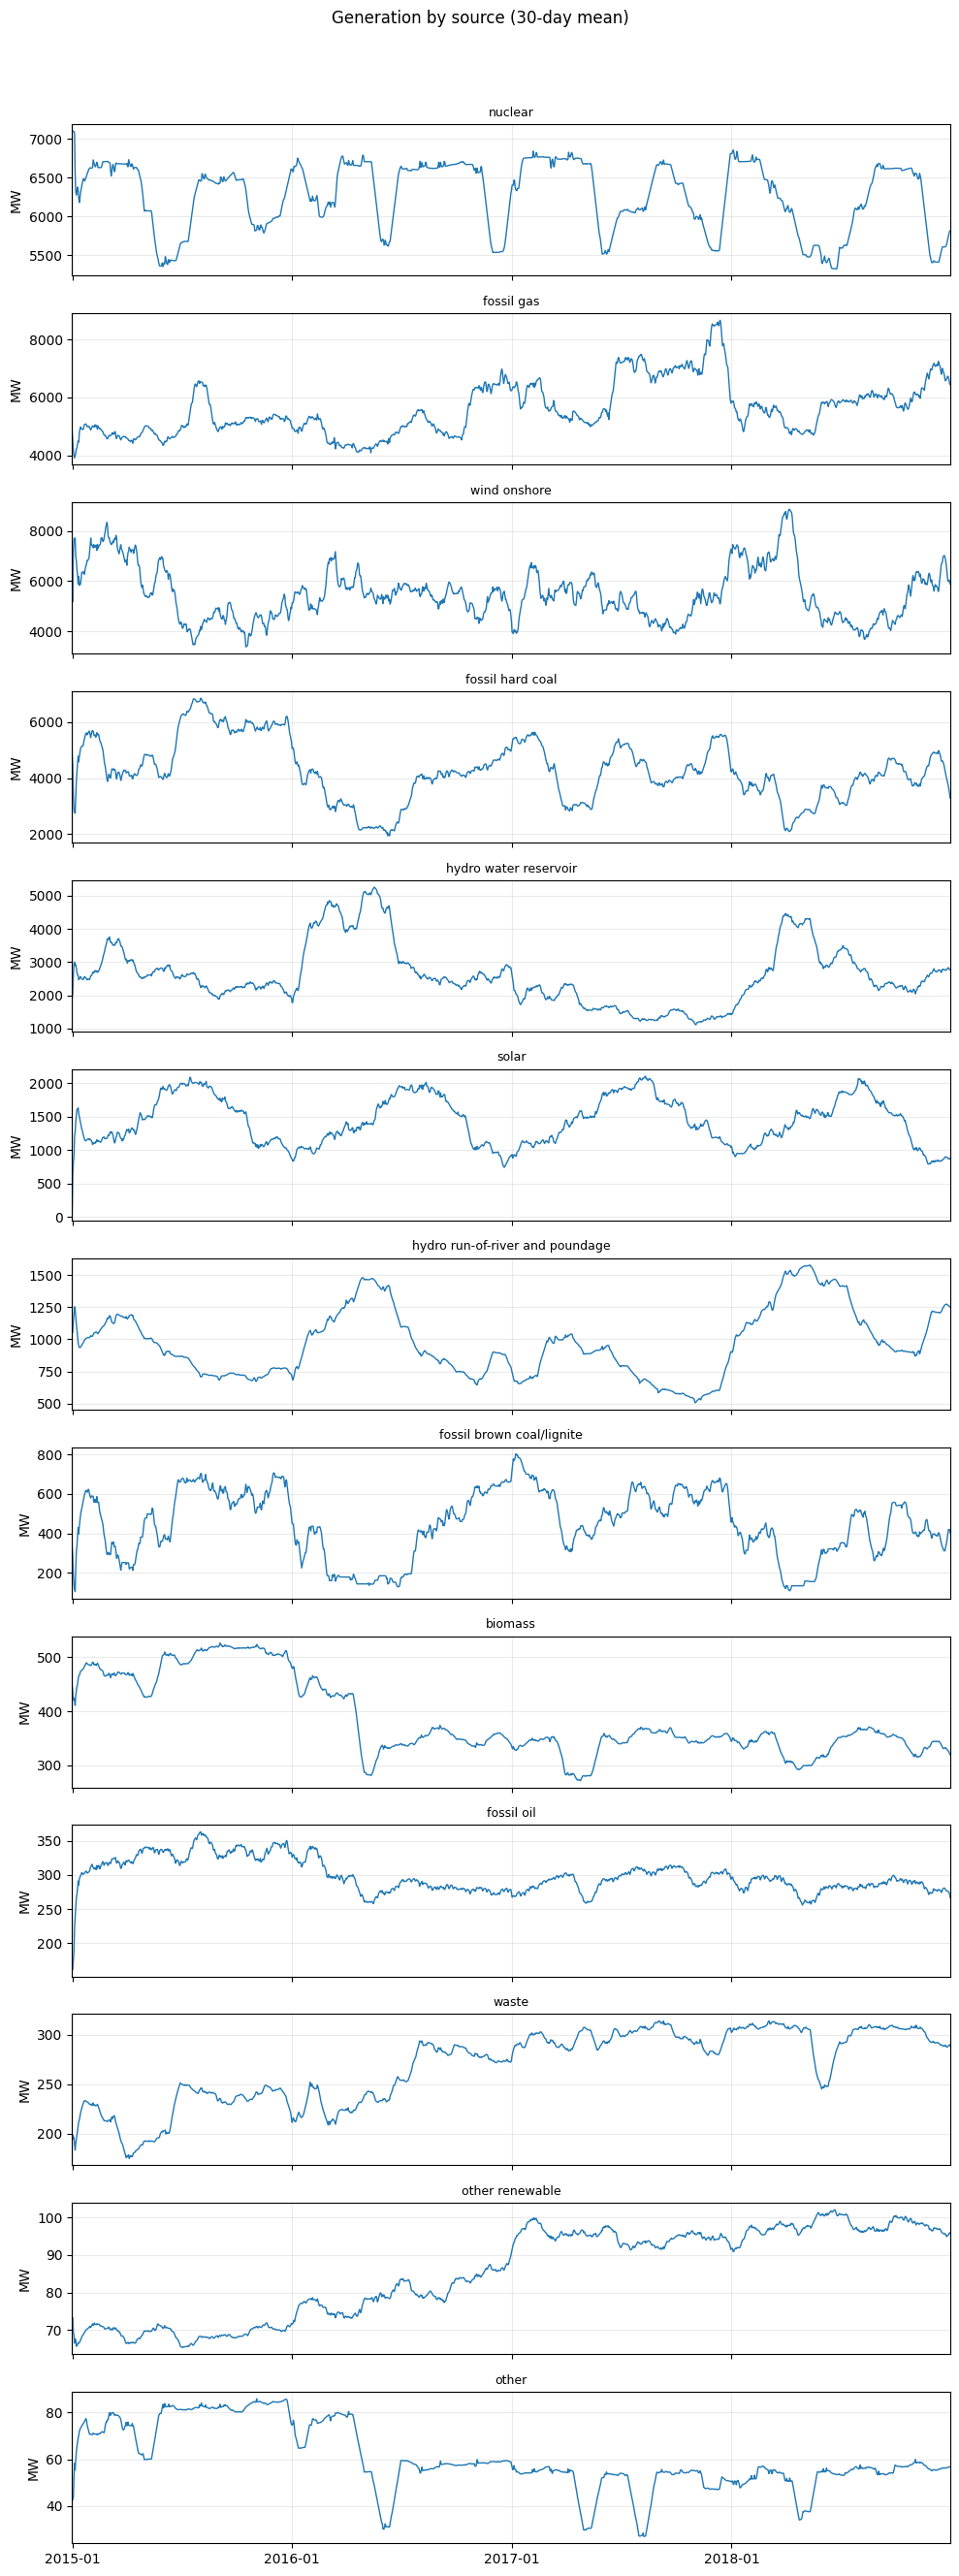

In [ ]:
# Generation by Source (30-day Mean): Small Multiples

import matplotlib.dates as mdates

# 1) Prepare series: daily mean + 30-day rolling mean; order by long-run average
gen_cols = [c for c in energy_data.columns
            if c.startswith('generation ') and 'pumped storage consumption' not in c]
gen_daily  = energy_data[gen_cols].resample('D').mean()
gen_roll30 = gen_daily.rolling(30, min_periods=1).mean()
order = gen_roll30.mean().sort_values(ascending=False).index
titles = [c.replace('generation ', '') for c in order]

# 2) Small multiples: share the same X axis across plots, keep independent Y axes
n = len(order); ncols = 1
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2*nrows), sharex=True)  # sharex=True !
axes = axes.ravel()

xmin, xmax = gen_roll30.index.min(), gen_roll30.index.max()
locator = mdates.YearLocator()       
fmt     = mdates.DateFormatter('%Y-%m')

for i, col in enumerate(order):
    ax = axes[i]
    ax.plot(gen_roll30.index, gen_roll30[col], linewidth=1.0)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlim(xmin, xmax)          
    ax.grid(True, alpha=0.25)
    if i % ncols == 0:
        ax.set_ylabel('MW')          
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

# 3) Hide X labels on inner plots; show them only on the bottom row
for ax in axes:
    ax.label_outer()

# Turn off any unused subplots (when grid has extra slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Generation by source (30-day mean)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


### 1.3 Summary

**Findings**

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind shows the largest short-term variability (week-to-week swings); solar is small but highly seasonal.

- Thermal fleet: Gas/coal act as flexible swing supply; medium-term level shifts (weeks–months) are present.

- Hydro: Reservoir/run-of-river modulate peaks and troughs with seasonal signatures.

- Forecast bias: Load/solar/wind forecasts show time-varying over/under-prediction periods.

**Actions**

1) Calendar & Seasonality

    - Features: hour, weekday, is_weekend, month/season, holiday flags; weekly & annual Fourier terms (k=3–10).

    - Why: clear weekday–hour rhythm and annual cycle in load/solar/hydro.

2) Lags & Rollings (short/medium/long)

    - For load and price: lags (1,2,3,6,12,24,48,168); rollings on shifted series (avoid leakage) with windows (24,48,168) → mean/std/min/max.

    - Why: strong autocorrelation and persistence; handles intra-day/weekly patterns.

3) Medium-term shifts

    - Rolling 30–90-day mean/median of key drivers (e.g., fossil gas, hard coal, reservoir hydro, net_load).

    - Why: panels show multi-week to multi-month level shifts; these stabilize the baseline.

4) Renewables & Supply Mix

    - Use day-ahead forecasts for wind/solar (known at prediction time) + lagged actuals.

    - Build generation shares = each source / total generation.

    - Build net load = total_load_actual − wind − solar (lagged).

    - Why: wind/solar variability and hydro modulation drive prices; shares capture structural effects.

5) Forecast-error features (bias correction)

    - For load/solar/wind: error_lag24 = (forecast − actual).shift(24), abs_error_lag24, rolling error std.

    - Why: we saw time-varying forecast bias; past errors help correct near-term bias.

6) Volatility signals (for price)

    - Price lags’ rolling std/IQR, lagged spikes indicators (e.g., price_lag1 > p95_lag), winsorized lag.

    - Why: price shows spikes/negatives; robust volatility cues improve calibration.

7) Regime flags & interactions

    - is_winter, is_summer, high_wind_regime (wind share > threshold), low_solar_season.

    - Interactions like is_winter × net_load_roll48.

    - Why: different regimes imply different elasticities.

8) Optional weather

    - If available: temp, HDD/CDD, humidity, clouds_all, wind speed (lagged or forecast).

    - Why: temperature drives load; clouds/wind speed explain renewables.

9) Scaling & encoding

    - Keep physical units; use RobustScaler for models that need it.

    - Fit scalers/encoders only on training windows.
